## Train ESN on ENSO TDE data

reproduce work from project

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [3]:
# read input data into dictionary
data = Dict()

data["full"] = CSV.read("data/sst_data/sst_34_anomaly_embedded.txt", DataFrame; delim=',', ignorerepeated=true)
data["train_data_80"] = CSV.read("data/sst_34_data_split_80/train_sst_34_anomaly_embedded_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["test_data_80"] = CSV.read("data/sst_34_data_split_80/test_sst_34_anomaly_embedded_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["val_data_80"] = CSV.read("data/sst_34_data_split_80/val_sst_34_anomaly_embedded_80.txt", DataFrame; delim=',', ignorerepeated=true)

# bring into correct format
data["full"] = Matrix(transpose(Matrix(data["full"])))
data["train_data_80"] = Matrix(transpose(Matrix(data["train_data_80"])))
data["test_data_80"] = Matrix(transpose(Matrix(data["test_data_80"])))
data["val_data_80"] = Matrix(transpose(Matrix(data["val_data_80"])))

data

Dict{Any, Any} with 4 entries:
  "full"          => [-0.2 -0.14 … -0.84 -0.69; 0.86 1.24 … 0.88 1.07; … ; -0.4…
  "train_data_80" => [0.08 -0.2 … 0.43 0.75; 0.27 0.86 … 0.82 0.83; … ; -0.33 -…
  "val_data_80"   => [0.63 0.51 … 0.86 0.9; 1.02 1.26 … 0.75 0.6; … ; 0.02 -0.4…
  "test_data_80"  => [0.67 0.71 … -0.84 -0.69; 0.42 0.15 … 0.88 1.07; … ; -0.14…

In [4]:
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.1, 0.14]
input_scales = [0.1, 1.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [ 130]

param_grid_80 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [5]:
esn_80, W_out_80, val_loss_80 = enso_project.cross_validate_esn(data["train_data_80"], data["val_data_80"], param_grid_80)

enso_project.ESNHyperparams(130, 0.8, 0.05, 0.1, 0.0)
Validation loss = 223240.07414745248
enso_project.ESNHyperparams(130, 0.9, 0.05, 0.1, 0.0)
Validation loss = 174.46448252285768
enso_project.ESNHyperparams(130, 0.8, 0.1, 0.1, 0.0)
Validation loss = 148.9947908736235
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 0.0)
Validation loss = 30.50979942909385
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 1.0e-6)
Validation loss = 30.49596650913812
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 1.0e-5)
Validation loss = 30.42386160998865


(ESN(5 => 130), OutputLayer successfully trained with output size: 5, 30.42386160998865)

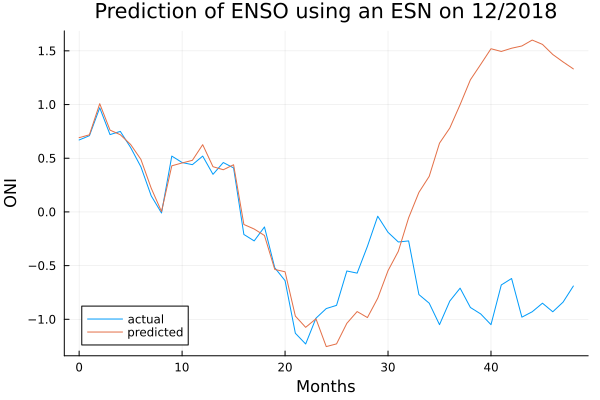

In [6]:
enso_project.plot_esn_prediction(esn_80, W_out_80, data["test_data_80"], "12/2018")

### Start prediction from later time steps

note: previous validation set starts at index 398. Test set starts at index 444 (i.e. December)

In [7]:
# store predictions
predictions = zeros(6, size(data["test_data_80"], 2));

method: keep training set fixed, change fraction of validation set to test set and retrain network.

In [8]:
pectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.1, 0.14, 0.2]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [110, 120, 125, 130, 135, 140, 150, 160]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [9]:
#Feb
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:446], param_grid)
predictions[1,1:size(data["full"][:, 447:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 447:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 333.3901619506924
enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
Validation loss = 272.9340298068641
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 132.2166722886952
enso_project.ESNHyperparams(125, 0.8, 0.1, 0.1, 0.0)
Validation loss = 119.74143644504882
enso_project.ESNHyperparams(125, 0.9, 0.14, 0.1, 0.0)
Validation loss = 87.6990206406601
enso_project.ESNHyperparams(130, 1.0, 0.1, 0.5, 0.0)
Validation loss = 78.06164488116633


In [10]:
#Apr
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:448], param_grid)
predictions[2,1:size(data["full"][:, 449:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 449:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 344.6408219977898
enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
Validation loss = 301.1390202394
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 137.2123518441079
enso_project.ESNHyperparams(125, 0.8, 0.1, 0.1, 0.0)
Validation loss = 127.28417503710284
enso_project.ESNHyperparams(125, 0.9, 0.14, 0.1, 0.0)
Validation loss = 91.12131248393794
enso_project.ESNHyperparams(130, 1.0, 0.1, 0.5, 0.0)
Validation loss = 79.35816951284964


In [11]:
#Jun
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:450], param_grid)
predictions[3,1:size(data["full"][:, 451:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 451:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 353.3908729750942
enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
Validation loss = 321.7997856336981
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 140.20863325503254
enso_project.ESNHyperparams(125, 0.8, 0.1, 0.1, 0.0)
Validation loss = 132.49659512950592
enso_project.ESNHyperparams(125, 0.9, 0.14, 0.1, 0.0)
Validation loss = 93.42594165459924
enso_project.ESNHyperparams(130, 1.0, 0.1, 0.5, 0.0)
Validation loss = 80.77650713817683


In [12]:
#Aug
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:452], param_grid)
predictions[4,1:size(data["full"][:, 453:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 453:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 359.9176632373689
enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
Validation loss = 334.80250650822865
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 143.77551851144256
enso_project.ESNHyperparams(125, 0.8, 0.1, 0.1, 0.0)
Validation loss = 141.0556560296412
enso_project.ESNHyperparams(125, 0.9, 0.14, 0.1, 0.0)
Validation loss = 96.53560076075965
enso_project.ESNHyperparams(130, 1.0, 0.1, 0.5, 0.0)
Validation loss = 85.1666999439917


In [13]:
#Oct
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:454], param_grid)
predictions[5,1:size(data["full"][:, 455:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 455:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 370.8141062417304
enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
Validation loss = 362.8362502239919
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 150.894608813807
enso_project.ESNHyperparams(125, 0.9, 0.14, 0.1, 0.0)
Validation loss = 106.7076882489159
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 0.0)
Validation loss = 106.01893426239594
enso_project.ESNHyperparams(130, 1.0, 0.1, 0.5, 0.0)
Validation loss = 96.05127249186975


In [14]:
#Dec
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:456], param_grid)
predictions[6,1:size(data["full"][:, 457:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 457:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 379.7198101858336
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 155.75428434633938
enso_project.ESNHyperparams(125, 0.9, 0.14, 0.1, 0.0)
Validation loss = 117.27770430841147
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 0.0)
Validation loss = 112.28428149019068
enso_project.ESNHyperparams(130, 1.0, 0.1, 0.5, 0.0)
Validation loss = 110.20505374149488
enso_project.ESNHyperparams(150, 0.8, 0.2, 0.1, 1.0e-5)
Validation loss = 101.26904430431678


In [15]:
predictions = predictions[:, 1:36] #make all same length
reference_data = data["full"][:, 457:end]

5×36 Matrix{Float64}:
  0.35   0.46   0.41  -0.21  -0.27  …  -0.93  -0.85  -0.93  -0.84  -0.69
 -0.52  -0.64  -1.13  -1.23  -0.99     -0.01   0.19   0.47   0.88   1.07
 -0.87  -0.55  -0.57  -0.32  -0.04      1.53   1.59   1.9    1.99   1.78
 -0.28  -0.27  -0.77  -0.85  -1.05      1.24   0.81   0.31   0.24   0.21
 -0.71  -0.89  -0.95  -1.05  -0.68     -0.15  -0.28  -0.14  -0.62  -0.71

### Compare plots

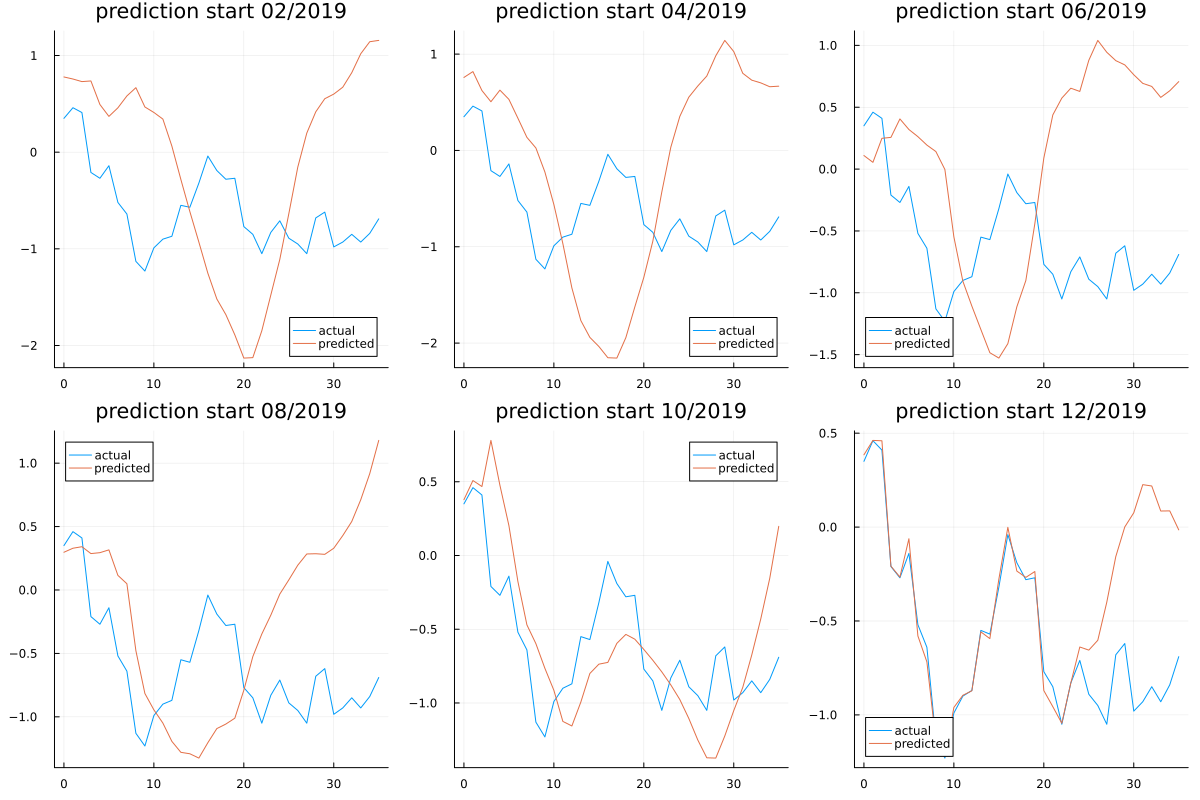

In [16]:
months = ["02/2019","04/2019","06/2019","08/2019","10/2019","12/2019"]
subplots = []
label = ["actual" "predicted"]
times =  collect(0:size(predictions,2))[1:end-1]
for i in eachindex(predictions[:,1])
    m = months[i]
    push!(subplots, plot(times, [reference_data[1,:], predictions[i, :]], label=label,  title="prediction start $m"))
end
plot(subplots..., layout=(2,3), size=(1200,800))